In [ ]:
import os
import pandas as pd

# If you're in Colab:
from google.colab import drive
drive.mount('/content/drive')

# Set your project path (same as before)
project_path = "/content/drive/MyDrive/Grooming-Detection-Academic-Study"
os.chdir(project_path)

print("Current working directory:", os.getcwd())
print("Items here:", os.listdir())

# Load processed dataset
df = pd.read_csv("data/processed/synthetic_chats_model_ready.csv")

print(df.shape)
df.head()


Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Grooming-Detection-Academic-Study
Items here: ['data', 'notebooks', 'synthetic_chats_raw.csv', 'docs']
(1830, 8)


,conversation_id,turn_id,speaker_role,text,label,stage,clean_text,label_num
0,0,0,child,my internet is lagging again omg.,non_grooming,none,my internet is lagging again omg,0
1,0,1,adult,"brb, need to finish homework.",non_grooming,none,brb need to finish homework,0
2,0,2,adult,"hey, you seem cool, what games do you usually ...",grooming,friendship_forming,hey you seem cool what games do you usually play,1
3,0,3,adult,"you seem different from other players, like I ...",grooming,trust_building,you seem different from other players like i a...,1
4,0,4,adult,"don’t tell your parents about our chats, they ...",grooming,isolation,dont tell your parents about our chats they wo...,1


In [ ]:
# Features and labels
X = df["clean_text"]
y = df["label_num"]

print("Example feature:", X.iloc[0])
print("Example label:", y.iloc[0])


Example feature: my internet is lagging again omg
Example label: 0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20% test
    stratify=y,         # keep same 0/1 ratio in train & test
    random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 1464
Test size: 366


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
log_reg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),      # unigrams + bigrams
        min_df=2,                # ignore very rare terms
        max_df=0.9               # ignore extremely common terms
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced", # handle class imbalance a bit
        random_state=42
    ))
])

# Train
log_reg_pipeline.fit(X_train, y_train)

print("Model trained.")


Model trained.


In [ ]:
# Predictions
y_pred = log_reg_pipeline.predict(X_test)

# Basic metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.000

Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       286
           1      1.000     1.000     1.000        80

    accuracy                          1.000       366
   macro avg      1.000     1.000     1.000       366
weighted avg      1.000     1.000     1.000       366

Confusion matrix:
[[286   0]
 [  0  80]]


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

svm_clf.fit(X_train, y_train)

svm_pred = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


SVM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      1.00      1.00        80

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(hidden_layer_sizes=(128,), max_iter=20, random_state=42))
])

mlp_clf.fit(X_train, y_train)

mlp_pred = mlp_clf.predict(X_test)

print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))


MLP Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      1.00      1.00        80

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Recreate df_test so the keyword baseline can use it
df_test = X_test.to_frame(name="clean_text")
df_test["label_num"] = y_test.values


In [ ]:
import re

# simple keyword list inspired by grooming literature
keywords = [
    "secret", "alone", "trust", "special", "private",
    "dont tell", "just us", "between us", "cute", "pics"
]

def keyword_detect(text):
    text = text.lower()
    return int(any(k in text for k in keywords))

keyword_pred = df_test["clean_text"].apply(keyword_detect)

print("Keyword Accuracy:", accuracy_score(y_test, keyword_pred))
print(classification_report(y_test, keyword_pred))


Keyword Accuracy: 0.8387978142076503
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       286
           1       1.00      0.26      0.42        80

    accuracy                           0.84       366
   macro avg       0.91      0.63      0.66       366
weighted avg       0.87      0.84      0.80       366



In [ ]:
import pandas as pd

# Collect model metrics
results = {
    "Model": ["Keyword Baseline", "Logistic Regression", "SVM", "MLP"],
    "Accuracy": [
        accuracy_score(y_test, keyword_pred),
        accuracy_score(y_test, y_pred),           # logistic
        accuracy_score(y_test, svm_pred),         # svm
        accuracy_score(y_test, mlp_pred),         # mlp
    ]
}

# Create DataFrame
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy
0,Keyword Baseline,0.838798
1,Logistic Regression,1.000000
2,SVM,1.000000
3,MLP,1.000000


In [ ]:
import os

print(os.listdir("/content/drive/MyDrive/Grooming-Detection-Academic-Study"))


['data', 'notebooks', 'synthetic_chats_raw.csv', 'docs']


In [ ]:
import os

project_path = "/content/drive/MyDrive/Grooming-Detection-Academic-Study"
os.chdir(project_path)

print("Now inside:", os.getcwd())
print("Folders:", os.listdir())


Now inside: /content/drive/MyDrive/Grooming-Detection-Academic-Study
Folders: ['data', 'notebooks', 'synthetic_chats_raw.csv', 'docs']


In [ ]:
results_df.to_csv("docs/modeling_results_summary.csv", index=False)
print("Saved modeling results to docs/modeling_results_summary.csv")


Saved modeling results to docs/modeling_results_summary.csv


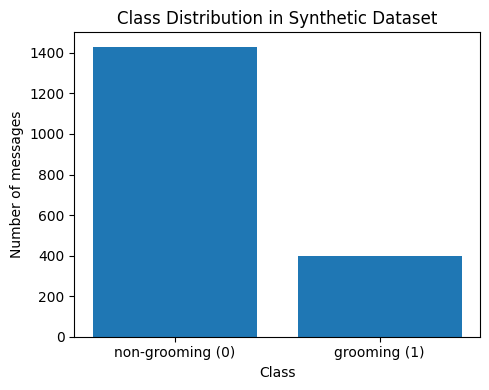

label_num
0    1430
1     400
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Assuming `df` is your full processed dataframe with `label_num`
# 1 = grooming, 0 = non-grooming

label_counts = df["label_num"].value_counts().sort_index()

plt.figure(figsize=(5, 4))
plt.bar(["non-grooming (0)", "grooming (1)"], label_counts.values)
plt.title("Class Distribution in Synthetic Dataset")
plt.ylabel("Number of messages")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

print(label_counts)


F1 scores:
Keyword baseline: 0.416
Logistic Regression: 1.000
SVM: 1.000
MLP: 1.000


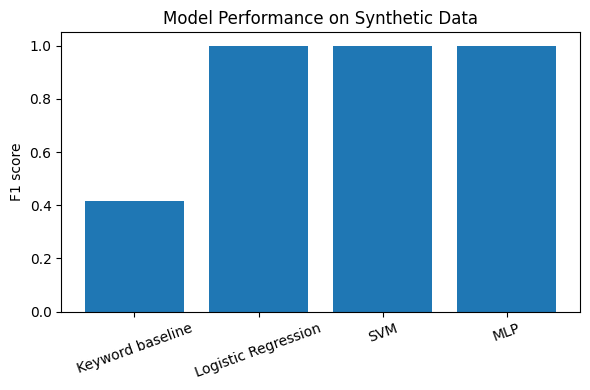

In [ ]:
from sklearn.metrics import f1_score

# 1) Predictions for each model
log_reg_pred = log_reg_pipeline.predict(X_test)
svm_pred = svm_clf.predict(X_test)
mlp_pred = mlp_clf.predict(X_test)

# 2) Keyword baseline on the same test set
keyword_pred = X_test.apply(keyword_detect)

# 3) Compute F1 scores
models = ["Keyword baseline", "Logistic Regression", "SVM", "MLP"]
f1_scores = [
    f1_score(y_test, keyword_pred),
    f1_score(y_test, log_reg_pred),
    f1_score(y_test, svm_pred),
    f1_score(y_test, mlp_pred),
]

print("F1 scores:")
for name, score in zip(models, f1_scores):
    print(f"{name}: {score:.3f}")

# 4) Bar chart
plt.figure(figsize=(6, 4))
plt.bar(models, f1_scores)
plt.ylabel("F1 score")
plt.title("Model Performance on Synthetic Data")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


<Figure size 400x400 with 0 Axes>

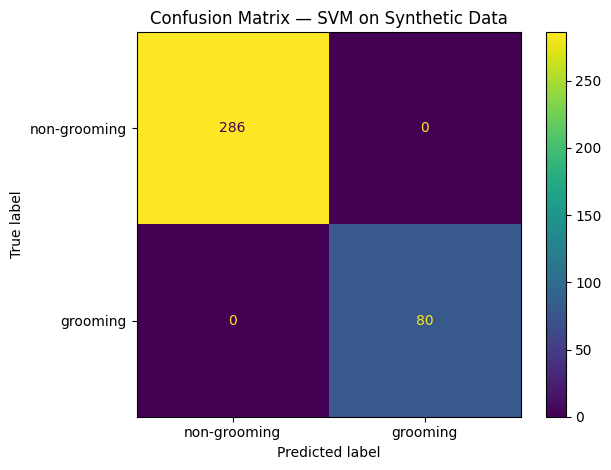

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for SVM (you can change to log_reg_pred or mlp_pred if you like)
cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-grooming", "grooming"])

plt.figure(figsize=(4, 4))
disp.plot(values_format="d")
plt.title("Confusion Matrix — SVM on Synthetic Data")
plt.tight_layout()
plt.show()
